## Combining the DataFrames

In [86]:
import pandas as pd
import numpy as np

df2 = pd.read_csv("../../annonymizedDatasets/maskedDAIsy_LabCombinedNew.csv", sep="\t")
df_vitals = pd.read_csv("../../annonymizedDatasets/maskedDAIsy_Vitals.csv", sep="\t")
df_age = pd.read_csv("../../annonymizedDatasets/maskedDAIsy_AllDatasetsCombinedWoRepIntakes_v1.tsv", sep = "\t")

### CHEMICAL DATAFRAME

In [57]:
# FILTERING OUT THE RELEVANT COLUMNS
items = ['Kalium', 'Leucocyten', 'ALAT (GPT)', 'ASAT (GOT)', 'Fosfaat anorganisch', 'Magnesium', 'Glucose (n.n.)']

df_items = df2[df2['O_ITEM'].isin(items)]

# df_items.head(10)

In [186]:
# PIVOTING THE DATAFRAME SO THAT ONE LINE IS ONE DATE'S CHEMICAL MEASUREMENT

def clean_column(value):
    if isinstance(value, str):
        if value.startswith("<"):
            return int(value[1:]) - 1  # Convert "<8" to 7
        elif value.isalpha():  # Check if the value is only letters
            return np.nan  # Replace letters with NaN
    return value  # Keep numeric values as they are

df_new = df_items.copy()

# Step 1: convert to datetime
df_new['p_DATE_BEPALING'] = pd.to_datetime(df_new['p_DATE_BEPALING'])

df_new['DATE'] = df_new['p_DATE_BEPALING'].dt.date

# Convert the date to UNIX timestamp for the model training
df_new['DATE'] = pd.to_datetime(df_new['DATE']).astype(int) / 10**9  # Unix timestamp (seconds)

# Drop the unnecessary columns
df_drop = df_new.drop(['STATUS_AANVRAAG', 'O_STATUS_UITSLAG', 'p_DATE_BEPALING'], axis=1)

# Reorder columns
df_reordered = df_drop.iloc[:, [0, 1, 3, 4, 2, 5, 6]]

df_reordered.rename(columns={'pid': 'PATIENT_ID', 'intid': 'INTAKE_ID','O_ITEM': 'CHEMICAL_VALUE', 'UITSLAG_WAARDE': 'VALUE_RESULT', 'NORMAALWAARDE': 'NORMAL_RANGE', 'seq_num-lab': 'SEQUENCE'}, inplace=True)

df_reordered.sort_values(by = 'PATIENT_ID')

df_pivot = df_reordered.pivot_table(index=['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE'], columns='CHEMICAL_VALUE', values='VALUE_RESULT', aggfunc='first')

df_pivot = df_pivot.rename_axis(None, axis=1)

pivoted_df = df_pivot.reset_index()

# Set a new index as the row number
pivoted_df['ROW'] = range(1, len(pivoted_df) + 1)
pivoted_df.set_index('ROW', inplace=True)

val_count = pivoted_df['PATIENT_ID'].value_counts()

pivot_df = pivoted_df[pivoted_df['PATIENT_ID'].isin(val_count[val_count >= 3].index)]

pivot_df = pivot_df.rename(columns={'ASAT (GOT)': 'AST', 'ALAT (GPT)': 'ALT', 'Fosfaat anorganisch': 'Phosphate', 'Kalium': 'Potassium', 'Leucocyten': 'Leucocytes', 'Glucose (n.n.)': 'Glucose'})

# pivot_df['ALT'] = pivot_df['ALT'].apply(clean_column)
pivot_df['AST'] = pivot_df['AST'].apply(clean_column)

cols_to_convert = ['Magnesium', 'ALT', 'AST', 'Phosphate', 'Glucose', 'Potassium', 'Leucocytes']
pivot_df[cols_to_convert] = pivot_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

pivot_df.loc[pivot_df['AST'] > 80, 'AST'] = np.nan
pivot_df.loc[pivot_df['ALT'] > 80, 'ALT'] = np.nan

pivot_df

,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,ALT,AST,Phosphate,Glucose,Potassium,Leucocytes,Magnesium
ROW,,,,,,,,,,,
2,10,934,1,5.367082e+09,26.0,25.0,1.22,3.8,4.0,3.6,0.73
3,10,934,2,5.367168e+09,25.0,23.0,1.11,4.1,4.3,4.1,0.73
4,10,934,3,5.367514e+09,32.0,20.0,1.37,4.3,4.3,5.0,0.70
5,10,934,4,5.367686e+09,26.0,17.0,1.25,4.4,4.2,4.4,0.70
6,10,934,5,5.367773e+09,24.0,17.0,1.23,4.3,4.6,4.5,0.70
...,...,...,...,...,...,...,...,...,...,...,...
5262,1601,1076,24,5.389286e+09,NaN,NaN,NaN,NaN,NaN,3.9,NaN
5263,1601,1076,24,5.389891e+09,NaN,10.0,1.36,4.6,4.3,NaN,0.75
5264,1601,1076,25,5.389891e+09,NaN,NaN,NaN,NaN,NaN,4.3,NaN


### VITALS DATAFRAME (BMI, BLOOD PRESSURE)

In [187]:
# Step 1: convert to datetime
df_vitals['p_DT_METING'] = pd.to_datetime(df_vitals['p_DT_METING'])

# Step 2: Extract the date and time separately
df_vitals['DATE'] = df_vitals['p_DT_METING'].dt.date
df_vitals['TIME'] = df_vitals['p_DT_METING'].dt.time

# Convert the date to UNIX timestamp for the model training
df_vitals['DATE'] = pd.to_datetime(df_vitals['DATE']).astype(int) / 10**9  # Unix timestamp (seconds)

# Drop the unnecessary columns
df_drop = df_vitals.drop(['Split', 'p_DT_METING', 'TIME'], axis=1)

# Reorder columns
df_reordered = df_drop.iloc[:, [0, 1, 2, 6, 3, 4, 5]]

df_reordered.rename(columns={'pid': 'PATIENT_ID', 'intid': 'INTAKE_ID','O_METING': 'MEASUREMENT ITEM', 'WAARDE1': 'VALUE 1', 'WAARDE2': 'VALUE 2', 'seq_num-vitals': 'SEQUENCE'}, inplace=True)

df_filtered = df_reordered[df_reordered['MEASUREMENT ITEM'].isin(['Body Mass Index', 'Tensie / Pols', 'Temperatuur (c)'])]

df_filtered.sort_values(by = ['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE'], inplace=True)
df_filtered.head(20)

vitals_df = df_filtered.reset_index()

vitals_df.drop('index', axis=1, inplace=True)

vitals_df

C:\Users\lev_pcj.kwaspen\AppData\Local\Temp\3\ipykernel_1660\2197394949.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by = ['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE'], inplace=True)


,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,MEASUREMENT ITEM,VALUE 1,VALUE 2
0,1,900,1,5.379869e+09,Body Mass Index,167.0,159.1
1,1,900,2,5.369587e+09,Body Mass Index,167.0,159.6
2,2,697,1,5.306515e+09,Body Mass Index,168.0,45.9
3,2,697,2,5.305910e+09,Body Mass Index,168.0,46.5
4,2,697,3,5.313773e+09,Body Mass Index,168.0,48.4
...,...,...,...,...,...,...,...
71890,1601,1076,418,5.389200e+09,Body Mass Index,173.5,49.2
71891,1601,1076,419,5.392397e+09,Body Mass Index,173.5,51.0
71892,1601,1076,420,5.389200e+09,Body Mass Index,173.5,49.2
71893,1606,1637,1,5.483981e+09,Body Mass Index,168.0,38.8


In [209]:
df_melted = vitals_df.melt(id_vars=['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE', 'MEASUREMENT ITEM'],
                     value_vars=['VALUE 1', 'VALUE 2'],
                     var_name='VALUE_TYPE',
                     value_name='VALUE')



# Create a unique identifier for multiple values of the same measurement
df_melted['MEASUREMENT ITEM'] = df_melted['MEASUREMENT ITEM'] + " " + df_melted.groupby(['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE', 'MEASUREMENT ITEM']).cumcount().add(1).astype(str)

# Pivot the table to get the desired structure
df_pivot = df_melted.pivot_table(index=['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE'],
                                 columns='MEASUREMENT ITEM',
                                 values='VALUE',
                                 aggfunc='first')

# Flatten the MultiIndex columns
df_pivot.columns = [col for col in df_pivot.columns]

# Reset index to get a clean DataFrame
df_finals = df_pivot.reset_index()

# Display the transformed DataFrame
df_finals.sort_values(by=['PATIENT_ID', 'INTAKE_ID', 'DATE'], inplace=True)

df_finals

,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,Body Mass Index 1,Body Mass Index 2,Temperatuur (c) 1,Tensie / Pols 1,Tensie / Pols 2
1,1,900,2,5.369587e+09,167.0,159.6,NaN,NaN,NaN
0,1,900,1,5.379869e+09,167.0,159.1,NaN,NaN,NaN
3,2,697,2,5.305910e+09,168.0,46.5,NaN,NaN,NaN
2,2,697,1,5.306515e+09,168.0,45.9,NaN,NaN,NaN
6,2,697,5,5.308330e+09,168.0,46.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
71782,1601,1076,274,5.394384e+09,NaN,NaN,NaN,114.0,78.0
71783,1601,1076,275,5.394384e+09,NaN,NaN,36.4,NaN,NaN
71879,1601,1076,414,5.394816e+09,173.5,55.7,NaN,NaN,NaN
71887,1606,1637,2,5.475859e+09,168.0,39.7,NaN,NaN,NaN


In [210]:
# Step 1: Calculate BMI
df_finals['Height (m)'] = df_finals['Body Mass Index 1'] / 100
df_finals['BMI'] = df_finals['Body Mass Index 2'] / (df_finals['Height (m)'] ** 2)

# Step 2: Drop the height column (Body Mass Index 1)
df_final1 = df_finals.drop(columns=['Body Mass Index 1'])

# Step 3: Rename the Tensie / Pols columns to Systolic and Diastolic
df_final2 = df_final1.rename(columns={
    'Tensie / Pols 1': 'Systolic',
    'Tensie / Pols 2': 'Diastolic',
    'Temperatuur (c) 1': 'Temperature (C)',
    'Body Mass Index 2': 'Weight (kg)'
})

# Step 4: Reorder the columns as required
df_vitals_final = df_final2.iloc[:, [0, 1, 2, 3, 4, 8, 9, 5, 6, 7]]

# Step 5: Sort the DataFrame by PATIENT_ID, INTAKE_ID, and DATE
df_final = df_vitals_final.sort_values(by=['PATIENT_ID', 'INTAKE_ID', 'DATE'])

# Step 6: Generate new SEQUENCE by grouping by PATIENT_ID and INTAKE_ID and using cumcount
df_final['SEQUENCE'] = df_final.groupby(['PATIENT_ID', 'INTAKE_ID']).cumcount() + 1

In [211]:
# Step 1: Group by PATIENT_ID, INTAKE_ID, and DATE, and aggregate the other columns
df_aggregated = df_final.groupby(['PATIENT_ID', 'INTAKE_ID', 'DATE'], as_index=False).agg({
    'Weight (kg)': 'first',  # Use the first non-null value for Weight
    'Height (m)': 'first',   # Use the first non-null value for Height
    'BMI': 'first',          # Use the first non-null value for BMI
    'Temperature (C)': 'first',  # Use the first non-null value for Temperature
    'Systolic': 'first',     # Use the first non-null value for Systolic
    'Diastolic': 'first'     # Use the first non-null value for Diastolic
})

# Step 2: Recalculate SEQUENCE after aggregation to ensure it's unique
df_aggregated['SEQUENCE'] = df_aggregated.groupby(['PATIENT_ID', 'INTAKE_ID']).cumcount() + 1

# Step 3: Sort the DataFrame by PATIENT_ID, INTAKE_ID, and DATE
df_aggregated = df_aggregated.sort_values(by=['PATIENT_ID', 'INTAKE_ID', 'DATE'])

# Check for any remaining duplicates
print(f"\nAfter Aggregating and Removing Duplicates:")
print(f"Length of DataFrame: {len(df_aggregated)}")

# Optionally check if any duplicates still exist for the same patient and intake
print(df_aggregated[df_aggregated.duplicated(subset=['PATIENT_ID', 'INTAKE_ID', 'DATE'], keep=False)])

df_aggregated


After Aggregating and Removing Duplicates:
Length of DataFrame: 32434
Empty DataFrame
Columns: [PATIENT_ID, INTAKE_ID, DATE, Weight (kg), Height (m), BMI, Temperature (C), Systolic, Diastolic, SEQUENCE]
Index: []


,PATIENT_ID,INTAKE_ID,DATE,Weight (kg),Height (m),BMI,Temperature (C),Systolic,Diastolic,SEQUENCE
0,1,900,5.369587e+09,159.6,1.670,57.226864,NaN,NaN,NaN,1
1,1,900,5.379869e+09,159.1,1.670,57.047581,NaN,NaN,NaN,2
2,2,697,5.305910e+09,46.5,1.680,16.475340,NaN,NaN,NaN,1
3,2,697,5.306515e+09,45.9,1.680,16.262755,NaN,NaN,NaN,2
4,2,697,5.308330e+09,46.6,1.680,16.510771,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...
32429,1601,1076,5.394298e+09,NaN,NaN,NaN,36.3,126.0,86.0,78
32430,1601,1076,5.394384e+09,44.3,1.735,14.716508,36.4,114.0,78.0,79
32431,1601,1076,5.394816e+09,55.7,1.735,18.503600,NaN,NaN,NaN,80
32432,1606,1637,5.475859e+09,39.7,1.680,14.066043,NaN,NaN,NaN,1


### AGE AND ED DATAFRAME

In [212]:
df_age['p_startdate'] = pd.to_datetime(df_age['p_startdate'])
df_age['DATE'] = df_age['p_startdate'].dt.date

# Convert the date to UNIX timestamp for the model training
df_age['DATE'] = pd.to_datetime(df_age['DATE']).astype(int) / 10**9  # Unix timestamp (seconds)

df_age['intid'] = df_age['intid'].astype(int)

df_age = df_age[df_age['EDtype'] == 'Anorexia nervosa']

cols = ['intid', 'seq_num-edeq', 'pid', 'DATE', 'Main-Age', 'Main-Bsex']

df_clean = df_age.loc[:, cols]

df_clean.rename(columns={'pid': 'PATIENT_ID', 'Main-Age': 'AGE', 'Main-Bsex': 'SEX', 'intid': 'INTAKE_ID', 'seq_num-edeq' : 'SEQUENCE'}, inplace=True)

df_clean['SEX'] = df_clean['SEX'].map({'Vrouw': 1, 'Man': 0})

df_reordered = df_clean.iloc[:, [2, 0, 1, 3, 5, 4]]

df_reordered.head(20)

,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,SEX,AGE
2,2,697,1,5.304096e+09,1,17
4,4,1315,1,5.429549e+09,1,19
8,9,1407,1,5.446224e+09,1,16
9,10,934,1,5.353690e+09,1,26
10,13,185,1,5.184000e+09,0,15
12,15,1402,1,5.445187e+09,1,21
13,16,1184,1,5.402938e+09,1,15
16,19,1653,1,5.487955e+09,1,16
18,21,614,1,5.284915e+09,1,20
20,24,1340,1,5.434733e+09,1,27


### MERGE DF_CHEM AND DF_AGE_BMI TOGETHER

In [213]:
# since we only want AN patients, we should first filter pivot_df based on all the PID that are still in df_reordered
# so that we only have AN patients in pivot_df before merging
pivot_df = pivot_df[pivot_df['PATIENT_ID'].isin(df_reordered['PATIENT_ID'])]
pivot_df.head()

df_merged = pivot_df.merge(df_reordered, on=['PATIENT_ID', 'INTAKE_ID'], how='left')

df_merged.rename(columns={'SEQUENCE_x': 'SEQUENCE', 'DATE_x' : 'DATE'}, inplace=True)

df_merged.drop(['DATE_y', 'SEQUENCE_y'], axis=1, inplace=True)

# df_merged = df_merged.iloc[:, [0,1,2,3, 10, 11, 12, 4,5,6,7,8,9,10]]

df_merged[df_merged['PATIENT_ID'] == 65]

,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,ALT,AST,Phosphate,Glucose,Potassium,Leucocytes,Magnesium,SEX,AGE
44,65,1168,1,5.402160e+09,37.0,49.0,1.17,4.0,3.2,6.8,1.00,1.0,20.0
45,65,1168,2,5.402246e+09,38.0,64.0,1.08,4.3,3.4,5.8,1.04,1.0,20.0
46,65,1168,3,5.402333e+09,NaN,NaN,NaN,NaN,NaN,5.5,NaN,1.0,20.0
47,65,1168,3,5.402592e+09,61.0,40.0,1.25,4.2,4.4,NaN,0.85,1.0,20.0
48,65,1168,4,5.402592e+09,NaN,NaN,NaN,NaN,NaN,6.8,NaN,1.0,20.0
49,65,1168,4,5.402765e+09,NaN,48.0,1.44,4.1,4.5,NaN,0.94,1.0,20.0
50,65,1168,5,5.402765e+09,NaN,NaN,NaN,NaN,NaN,6.7,NaN,1.0,20.0
51,65,1168,5,5.402851e+09,NaN,51.0,1.42,3.9,4.4,NaN,0.90,1.0,20.0
52,65,1168,6,5.402851e+09,NaN,NaN,NaN,NaN,NaN,7.2,NaN,1.0,20.0
53,65,1168,6,5.403197e+09,NaN,39.0,1.37,4.5,4.6,NaN,0.88,1.0,20.0


In [205]:
merged_df = df_merged.groupby(['PATIENT_ID', 'DATE'], as_index=False).agg({
    'INTAKE_ID': 'first',
    'SEQUENCE': 'first',  # Assuming the sequence number is the same within a day
    'AGE': 'first',  # Assuming age remains constant
    'SEX': 'first',  # Assuming sex remains constant
    'ALT': 'first',  # First non-null value
    'AST': 'first',  # First non-null value
    'Phosphate': 'first',  # First non-null value
    'Glucose': 'first',  # First non-null value
    'Potassium': 'first',  # First non-null value
    'Leucocytes': 'first',  # First non-null value
    'Magnesium': 'first' # First non-null value
})

# Check the result
merged_df[merged_df['PATIENT_ID'] == 65]

,PATIENT_ID,DATE,INTAKE_ID,SEQUENCE,AGE,SEX,ALT,AST,Phosphate,Glucose,Potassium,Leucocytes,Magnesium
44,65,5.402160e+09,1168,1,20.0,1.0,37.0,49.0,1.17,4.0,3.2,6.8,1.00
45,65,5.402246e+09,1168,2,20.0,1.0,38.0,64.0,1.08,4.3,3.4,5.8,1.04
46,65,5.402333e+09,1168,3,20.0,1.0,NaN,NaN,NaN,NaN,NaN,5.5,NaN
47,65,5.402592e+09,1168,3,20.0,1.0,61.0,40.0,1.25,4.2,4.4,6.8,0.85
48,65,5.402765e+09,1168,4,20.0,1.0,NaN,48.0,1.44,4.1,4.5,6.7,0.94
49,65,5.402851e+09,1168,5,20.0,1.0,NaN,51.0,1.42,3.9,4.4,7.2,0.90
50,65,5.403197e+09,1168,6,20.0,1.0,NaN,39.0,1.37,4.5,4.6,7.3,0.88
51,65,5.403456e+09,1168,7,20.0,1.0,NaN,42.0,1.31,4.5,4.4,5.9,0.88
52,65,5.403802e+09,1168,8,20.0,1.0,NaN,23.0,1.35,4.1,4.5,6.7,0.82
53,65,5.404061e+09,1168,9,20.0,1.0,NaN,23.0,1.43,4.8,4.4,6.8,0.83


In [214]:
df_aggregated

,PATIENT_ID,INTAKE_ID,DATE,Weight (kg),Height (m),BMI,Temperature (C),Systolic,Diastolic,SEQUENCE
0,1,900,5.369587e+09,159.6,1.670,57.226864,NaN,NaN,NaN,1
1,1,900,5.379869e+09,159.1,1.670,57.047581,NaN,NaN,NaN,2
2,2,697,5.305910e+09,46.5,1.680,16.475340,NaN,NaN,NaN,1
3,2,697,5.306515e+09,45.9,1.680,16.262755,NaN,NaN,NaN,2
4,2,697,5.308330e+09,46.6,1.680,16.510771,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...
32429,1601,1076,5.394298e+09,NaN,NaN,NaN,36.3,126.0,86.0,78
32430,1601,1076,5.394384e+09,44.3,1.735,14.716508,36.4,114.0,78.0,79
32431,1601,1076,5.394816e+09,55.7,1.735,18.503600,NaN,NaN,NaN,80
32432,1606,1637,5.475859e+09,39.7,1.680,14.066043,NaN,NaN,NaN,1


### Final DF Merge asof()

In [215]:
### THIS WORKS - NORMAL MERGING

# df_aggregated['DATE'] = pd.to_datetime(df_aggregated['DATE'], errors='coerce')
# merged_df['DATE'] = pd.to_datetime(merged_df['DATE'], errors='coerce')

# Perform the normal merge on 'DATE', 'PATIENT_ID', 'INTAKE_ID'
df_combined = pd.merge(merged_df, df_aggregated, on=['DATE', 'PATIENT_ID', 'INTAKE_ID'], how='left', suffixes=('_final', '_merged'))

df_combined = df_combined.rename(columns={'SEQUENCE_final': 'SEQUENCE'})
df_combined = df_combined.drop(columns=['SEQUENCE_merged'])

new_column_order = ['PATIENT_ID', 'INTAKE_ID', 'SEQUENCE', 'DATE', 'AGE', 'SEX', 'Weight (kg)', 'Height (m)', 'BMI', 'Temperature (C)', 'Systolic', 'Diastolic', 'ALT', 'AST', 'Phosphate', 'Glucose', 'Potassium', 'Leucocytes', 'Magnesium']

# Reorder the columns in the DataFrame
df_combined = df_combined[new_column_order]

columns_to_convert = ['ALT', 'AST', 'Phosphate', 'Glucose', 'Potassium', 'Leucocytes', 'Magnesium']

# Convert each column to numeric, coercing errors to NaN
df_combined[columns_to_convert] = df_combined[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# fill height based on already available height somewhere else in rows for specific patient
df_combined['Height (m)'] = df_combined.groupby('PATIENT_ID')['Height (m)'].transform(lambda x: x.ffill().bfill())

# Convert specific temperature values to NaN
df_combined['Temperature (C)'] = df_combined['Temperature (C)'].replace([43, 33.7], float('nan'))

# Convert systolic and diastolic values of 0 to NaN
df_combined['Systolic'] = df_combined['Systolic'].replace(0, float('nan'))
df_combined['Diastolic'] = df_combined['Diastolic'].replace(0, float('nan'))

# # Display the merged dataframe to check
df_combined

,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,AGE,SEX,Weight (kg),Height (m),BMI,Temperature (C),Systolic,Diastolic,ALT,AST,Phosphate,Glucose,Potassium,Leucocytes,Magnesium
0,10,934,1,5.367082e+09,26.0,1.0,44.50,1.570,18.053471,36.1,107.0,70.0,26.0,25.0,1.22,3.8,4.0,3.6,0.73
1,10,934,2,5.367168e+09,26.0,1.0,45.45,1.570,18.438882,35.2,NaN,NaN,25.0,23.0,1.11,4.1,4.3,4.1,0.73
2,10,934,3,5.367514e+09,26.0,1.0,44.50,1.570,18.053471,NaN,NaN,NaN,32.0,20.0,1.37,4.3,4.3,5.0,0.70
3,10,934,4,5.367686e+09,26.0,1.0,NaN,1.570,NaN,NaN,NaN,NaN,26.0,17.0,1.25,4.4,4.2,4.4,0.70
4,10,934,5,5.367773e+09,26.0,1.0,NaN,1.570,NaN,NaN,NaN,NaN,24.0,17.0,1.23,4.3,4.6,4.5,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,1601,1076,21,5.388077e+09,29.0,1.0,42.80,1.735,14.218206,36.4,129.0,85.0,15.0,7.0,1.45,NaN,4.5,4.2,0.76
1918,1601,1076,22,5.388682e+09,29.0,1.0,NaN,1.735,NaN,NaN,NaN,NaN,12.0,13.0,1.48,5.1,4.4,4.0,0.76
1919,1601,1076,23,5.389286e+09,29.0,1.0,NaN,1.735,NaN,NaN,NaN,NaN,12.0,8.0,1.53,4.5,4.1,3.9,0.75
1920,1601,1076,24,5.389891e+09,29.0,1.0,45.70,1.735,15.181589,35.7,125.0,81.0,NaN,10.0,1.36,4.6,4.3,4.3,0.75


In [216]:
df_combined.to_csv('BEP.csv', index=False)

In [217]:
nan_counts = df_combined.isna().sum()

# Display the NaN counts
print("\nDataframe length: ", len(df_combined))
print("\nNaN Counts per Column:")
print(nan_counts)


Dataframe length:  1922

NaN Counts per Column:
PATIENT_ID           0
INTAKE_ID            0
SEQUENCE             0
DATE                 0
AGE                 40
SEX                 40
Weight (kg)        974
Height (m)          88
BMI                974
Temperature (C)    933
Systolic           940
Diastolic          941
ALT                235
AST                101
Phosphate           39
Glucose            419
Potassium           29
Leucocytes          32
Magnesium           41
dtype: int64


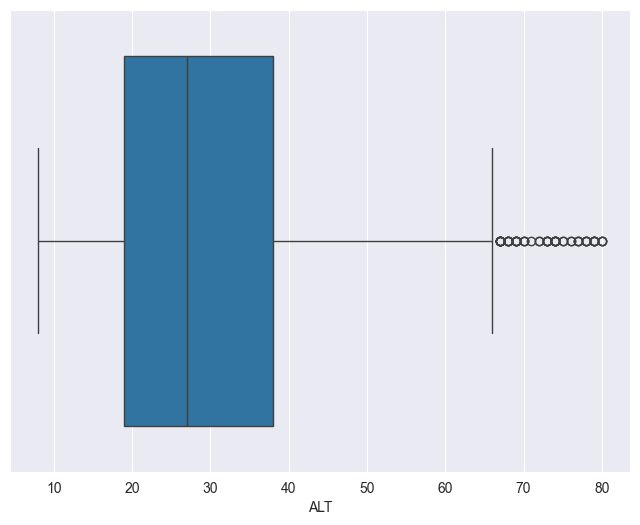

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot for the 'weight' column
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
sns.boxplot(x=df_combined['ALT'])

# Show the plot
plt.show()

In [218]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import miceforest as mf

# Load the data
df = pd.read_csv('BEP.csv')

# print("Original DataFrame with missing values:")
# print(df.head())  # Print only the first few rows for readability

# Columns to impute
cols_to_impute = ['Weight (kg)', 'Temperature (C)', 'Systolic',
                  'Diastolic', 'ALT', 'AST', 'Phosphate',
                  'Glucose', 'Potassium', 'Leucocytes', 'Magnesium']

# Select only columns that need imputation
df_subset = df[cols_to_impute].copy()

kernel = mf.ImputationKernel(
    df_subset,
    num_datasets=3,
    random_state=123
)

# the default is random forest, use candidates > 0 for PMM
kernel.mice(
    iterations=10,
    mean_match_candidates=5  # Enables PMM by selecting the 5 closest donors (PMM if positive int)
)

imputed_df = kernel.complete_data(dataset=0)

# # Merge imputed values back into the original dataframe
df[cols_to_impute] = imputed_df

# Calculate BMI
df['BMI'] = df['BMI'].fillna(df['Weight (kg)'] / (df['Height (m)'] ** 2))

print("\nDataFrame after MICE Imputation:")

df.to_csv('BEP_imputed.csv', index=False)
df


DataFrame after MICE Imputation:


,PATIENT_ID,INTAKE_ID,SEQUENCE,DATE,AGE,SEX,Weight (kg),Height (m),BMI,Temperature (C),Systolic,Diastolic,ALT,AST,Phosphate,Glucose,Potassium,Leucocytes,Magnesium
0,10,934,1,5.367082e+09,26.0,1.0,44.50,1.570,18.053471,36.1,107.0,70.0,26.0,25.0,1.22,3.8,4.0,3.6,0.73
1,10,934,2,5.367168e+09,26.0,1.0,45.45,1.570,18.438882,35.2,127.0,65.0,25.0,23.0,1.11,4.1,4.3,4.1,0.73
2,10,934,3,5.367514e+09,26.0,1.0,44.50,1.570,18.053471,36.8,117.0,75.0,32.0,20.0,1.37,4.3,4.3,5.0,0.70
3,10,934,4,5.367686e+09,26.0,1.0,44.50,1.570,18.053471,36.2,105.0,88.0,26.0,17.0,1.25,4.4,4.2,4.4,0.70
4,10,934,5,5.367773e+09,26.0,1.0,44.70,1.570,18.134610,36.0,96.0,79.0,24.0,17.0,1.23,4.3,4.6,4.5,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,1601,1076,21,5.388077e+09,29.0,1.0,42.80,1.735,14.218206,36.4,129.0,85.0,15.0,7.0,1.45,4.0,4.5,4.2,0.76
1918,1601,1076,22,5.388682e+09,29.0,1.0,48.90,1.735,16.244633,36.5,134.0,91.0,12.0,13.0,1.48,5.1,4.4,4.0,0.76
1919,1601,1076,23,5.389286e+09,29.0,1.0,47.50,1.735,15.779551,36.8,122.0,80.0,12.0,8.0,1.53,4.5,4.1,3.9,0.75
1920,1601,1076,24,5.389891e+09,29.0,1.0,45.70,1.735,15.181589,35.7,125.0,81.0,13.0,10.0,1.36,4.6,4.3,4.3,0.75


In [175]:
### TRY 1 OF IMPUTING ON PATIENT LEVEL

# import pandas as pd
# import miceforest as mf
#
# # Load the data
# df = pd.read_csv('BEP.csv')
#
# df = df.reset_index(drop = True)
#
# # Columns to impute
# cols_to_impute = ['Weight (kg)', 'Temperature (C)', 'Systolic',
#                   'Diastolic', 'ALT', 'AST', 'Phosphate',
#                   'Glucose', 'Potassium', 'Leucocytes', 'Magnesium']
#
# # Function to apply MICE imputation per patient
# def impute_per_patient(patient_data):
#
#     if patient_data[cols_to_impute].isnull().sum().sum() == 0:
#         return patient_data  # Skip if no missing values
#
#     df_subset = patient_data[cols_to_impute].copy()  # Extract only the columns needing imputation
#
#     df_subset = df_subset.reset_index()
#
#     print(df_subset.index)
#
#     kernel = mf.ImputationKernel(
#         df_subset,
#         num_datasets=3,
#         random_state=123
#     )
#
#     # Run MICE
#     kernel.mice(iterations=10, mean_match_candidates=5)
#
#     # Get the imputed dataset
#     imputed_data = kernel.complete_data(dataset=0)
#
#     # Merge imputed values back
#     patient_data[cols_to_impute] = imputed_data
#
#     return patient_data
#
# # Apply MICE within each patient group
# df_imp = df.groupby("PATIENT_ID", group_keys=False).apply(impute_per_patient)
#
# # Recalculate BMI if missing
# df_imp['BMI'] = df_imp['BMI'].fillna(df_imp['Weight (kg)'] / (df_imp['Height (m)'] ** 2))
#
# # Print the updated DataFrame
# df_imp.head()

In [178]:
### TRY 2 OF IMPUTING ON PATIENT LEVEL

# import pandas as pd
# import miceforest as mf
#
# cols_to_impute = ['Weight (kg)', 'Temperature (C)', 'Systolic',
#                   'Diastolic', 'ALT (GPT)', 'AST (GOT)', 'Phosphate unorganic',
#                   'Glucose (n.n.)', 'Potassium', 'Leucocytes', 'Magnesium']
#
# unique_ID = df['PATIENT_ID'].unique().tolist()
#
# def mice(df):
#     df.reset_index(inplace = True)
#
#     print(df)
#     kernel = mf.ImputationKernel(
#         df,
#         num_datasets=3,
#         random_state=123
#     )
#     kernel.mice(
#         iterations=10,
#         mean_match_candidates=5
#     )
#     return kernel.complete_data(dataset=0)
#
# imputed_data = []  # List to store imputed patient data
#
# for id in unique_ID:
#     df_sub = df[df['PATIENT_ID'] == id]
#     df_subset = df_sub[cols_to_impute].copy()
#
#     # Keep track of the patient ID
#     df_subset['PATIENT_ID'] = id
#
#     df_new = mice(df_subset)
#
#     imputed_data.append(df_new)  # Store in list
#
# # Combine all imputed data efficiently
# merged_df = pd.concat(imputed_data, ignore_index=True)
#
# # Reorder columns to move PATIENT_ID to the first column
# merged_df = merged_df[['PATIENT_ID'] + [col for col in cols_to_impute]]


In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin = -1, vmax = 1)

plt.show()

ValueError: could not convert string to float: '2140-01-29'

<Figure size 1200x800 with 0 Axes>

### Creating Time Features

In [202]:
### LAG FEATURES

# List of columns to create lag features for
columns_to_lag = [
    'ALT (GPT)', 'AST (GOT)', 'Phosphate unorganic', 'Glucose (n.n.)', 'Potassium',
    'Magnesium', 'Weight (kg)', 'BMI', 'Temperature (C)', 'Systolic', 'Diastolic'
]

# Create lag features (lag 1, lag 2, lag 3)
for col in columns_to_lag:
    for lag in range(1, 4):
        df[f'{col}_lag{lag}'] = df.groupby('PATIENT_ID')[col].shift(lag)

In [200]:
### RATE OF CHANGE

for col in columns_to_lag:
    # Absolute rate of change (delta)
    df[f'{col}_delta'] = df.groupby('PATIENT_ID')[col].diff()

    # Percentage rate of change
    df[f'{col}_percent_change'] = df.groupby('PATIENT_ID')[col].pct_change() * 100

In [205]:
df.to_csv('BEP_timefeat.csv', index=False)